## Import Modules

In [1]:
#import modules
from statsbombpy import sb

import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier

import numpy as np
import math
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
from bs4 import BeautifulSoup
import requests

## Define specialized variables

In [3]:
match_week_stage = math.floor((3/4)*38)
print(match_week_stage)

28


## Obtain League and shots data from Statsbomb

In [4]:
competitions = sb.competitions()

In [5]:
#events.columns

In [6]:
competitions[
    (competitions['competition_name'].isin([
    'Premier League', '1. Bundesliga', 'La Liga', 'Ligue 1', 'Serie A']))
             & 
    (competitions['season_name']=='2015/2016')
            ]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2023-12-12T07:43:33.436182,None,None,2023-12-12T07:43:33.436182
41,11,27,Spain,La Liga,male,False,False,2015/2016,2023-09-20T17:21:32.111535,2021-06-13T16:17:31.694,None,2023-09-20T17:21:32.111535
58,7,27,France,Ligue 1,male,False,False,2015/2016,2023-12-13T00:27:57.162379,None,None,2023-12-13T00:27:57.162379
62,2,27,England,Premier League,male,False,False,2015/2016,2023-11-14T11:25:33.476498,2021-06-13T16:17:31.694,None,2023-11-14T11:25:33.476498
64,12,27,Italy,Serie A,male,False,False,2015/2016,2023-12-13T17:32:46.423081,None,None,2023-12-13T17:32:46.423081


In [7]:
LaLiga = sb.matches(competition_id=11, season_id=27)
LaLiga.head()

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
0,3825848,2015-09-23,20:00:00.000,Spain - La Liga,2015/2016,Levante UD,Eibar,2,2,available,...,None,5,Regular Season,Estadio Ciudad de Valencia,NaN,Luis Lucas Alcaraz González,José Luis Mendilibar Etxebarria,1.1.0,2,2
1,3825895,2015-09-23,22:00:00.000,Spain - La Liga,2015/2016,Las Palmas,Sevilla,2,0,available,...,None,5,Regular Season,Estadio de Gran Canaria,Carlos del Cerro Grande,Francisco Herrera Lorenzo,Unai Emery Etxegoien,1.1.0,2,2
2,3825894,2016-05-01,18:15:00.000,Spain - La Liga,2015/2016,RC Deportivo La Coruña,Getafe,0,2,available,...,None,36,Regular Season,Estadio Abanca-Riazor,Carlos Clos Gómez,Víctor Sánchez del Amo,Juan Eduardo Esnáider Belén,1.1.0,2,2
3,3825855,2016-05-02,20:30:00.000,Spain - La Liga,2015/2016,Málaga,Levante UD,3,1,available,...,None,36,Regular Season,Estadio La Rosaleda,Iñaki Bikandi Garrido,Javier Gracia Carlos,Joan Francesc Ferrer Sicilia,1.1.0,2,2
4,3825908,2016-05-15,19:00:00.000,Spain - La Liga,2015/2016,Espanyol,Eibar,4,2,available,...,None,38,Regular Season,RCDE Stadium,Mario Melero López,Constantin Gâlcă,José Luis Mendilibar Etxebarria,1.1.0,2,2


In [8]:
LaLiga.columns

Index(['match_id', 'match_date', 'kick_off', 'competition', 'season',
       'home_team', 'away_team', 'home_score', 'away_score', 'match_status',
       'match_status_360', 'last_updated', 'last_updated_360', 'match_week',
       'competition_stage', 'stadium', 'referee', 'home_managers',
       'away_managers', 'data_version', 'shot_fidelity_version',
       'xy_fidelity_version'],
      dtype='object')

In [9]:
print(pd.unique(LaLiga['home_team']))

['Levante UD' 'Las Palmas' 'RC Deportivo La Coruña' 'Málaga' 'Espanyol'
 'Sporting Gijón' 'Rayo Vallecano' 'Real Betis' 'Athletic Club'
 'Atlético Madrid' 'Valencia' 'Eibar' 'Getafe' 'Villarreal' 'Sevilla'
 'Granada' 'Real Sociedad' 'Celta Vigo' 'Real Madrid' 'Barcelona']


In [10]:
LaLiga.iloc[0]

match_id                                         3825848
match_date                                    2015-09-23
kick_off                                    20:00:00.000
competition                              Spain - La Liga
season                                         2015/2016
home_team                                     Levante UD
away_team                                          Eibar
home_score                                             2
away_score                                             2
match_status                                   available
match_status_360                             unscheduled
last_updated                  2023-02-21T15:19:45.745471
last_updated_360                                    None
match_week                                             5
competition_stage                         Regular Season
stadium                       Estadio Ciudad de Valencia
referee                                              NaN
home_managers                Lu

In [11]:
example = sb.events(match_id=3754037)
example.columns

Index(['ball_receipt_outcome', 'ball_recovery_offensive',
       'ball_recovery_recovery_failure', 'carry_end_location',
       'clearance_aerial_won', 'clearance_body_part', 'clearance_head',
       'clearance_left_foot', 'clearance_right_foot', 'counterpress',
       'dribble_nutmeg', 'dribble_outcome', 'dribble_overrun', 'duel_outcome',
       'duel_type', 'duration', 'foul_committed_advantage',
       'foul_committed_card', 'foul_committed_offensive',
       'foul_committed_type', 'foul_won_advantage', 'foul_won_defensive',
       'goalkeeper_body_part', 'goalkeeper_end_location', 'goalkeeper_outcome',
       'goalkeeper_position', 'goalkeeper_technique', 'goalkeeper_type', 'id',
       'index', 'interception_outcome', 'location', 'match_id', 'minute',
       'miscontrol_aerial_won', 'off_camera', 'out', 'pass_aerial_won',
       'pass_angle', 'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_end_location', 'pass_goal_assist', 'pass_height',
   

In [12]:
relevant_attributes = ['minute', 'second', 'team', 'shot_statsbomb_xg',
                       'player', 'position', 'location', 'shot_body_part',
       'shot_end_location', 'shot_first_time', 
         'shot_technique',
       'shot_type', 'type','shot_outcome', 'under_pressure']

## Obtain dataframe of all shots up to our matchweek stage

In [13]:
LaLiga_shots_df = pd.DataFrame(columns=relevant_attributes)

In [14]:
start = time.time()
for match in LaLiga[LaLiga['match_week']<=match_week_stage]['match_id']:
    match_df = sb.events(match_id=match)
    relevant_match_df = match_df[relevant_attributes][match_df['type']=='Shot']
    LaLiga_shots_df = pd.concat([LaLiga_shots_df, relevant_match_df], ignore_index=True)

LaLiga_shots_df['shot_outcome'] = LaLiga_shots_df['shot_outcome'].replace(
    to_replace={'Off T': 0, 'Blocked': 0, 'Saved': 0, 'Goal': 1, 'Wayward': 0, 'Post': 0,
               'Saved to Post': 0, 'Saved Off Target': 0})

LaLiga_shots_df['distance'] = LaLiga_shots_df.apply(lambda row: np.sqrt(np.abs(
    row.location[0]-120)**2 + np.abs(row.location[1]-40)**2), axis=1)
LaLiga_shots_df['shot_angle'] = LaLiga_shots_df.apply(
    lambda row: np.arctan2(np.abs(40-row.location[1]), np.abs(120-row.location[0])), axis=1)
end = time.time()
print(f'script run time: {(end - start)/60} minutes')
LaLiga_shots_df

script run time: 4.625882132848104 minutes


,minute,second,team,shot_statsbomb_xg,player,position,location,shot_body_part,shot_end_location,shot_first_time,shot_technique,shot_type,type,shot_outcome,under_pressure,distance,shot_angle
0,2,58,Levante UD,0.100429,Jefferson Andrés Lerma Solís,Left Center Midfield,"[112.5, 42.1]",Head,"[120.0, 41.5, 5.9]",NaN,Normal,Open Play,Shot,0,True,7.788453,0.273009
1,8,33,Eibar,0.023138,Sergio Gontán Gallardo,Right Wing,"[90.9, 39.9]",Right Foot,"[119.1, 42.5, 0.8]",NaN,Normal,Open Play,Shot,0,NaN,29.100172,0.003436
2,9,26,Eibar,0.034535,Adrián González Morales,Center Attacking Midfield,"[103.1, 52.5]",Right Foot,"[104.5, 51.8]",True,Half Volley,Open Play,Shot,0,NaN,21.020466,0.636841
3,9,49,Eibar,0.394774,Borja González Tomás,Center Forward,"[116.6, 38.6]",Head,"[120.0, 37.0, 1.2]",NaN,Normal,Open Play,Shot,1,True,3.676955,0.390607
4,15,40,Levante UD,0.077194,Nabil Ghilas,Right Center Forward,"[112.4, 35.8]",Head,"[120.0, 34.8, 6.6]",NaN,Normal,Open Play,Shot,0,True,8.683317,0.504861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6791,79,27,Barcelona,0.297600,Neymar da Silva Santos Junior,Left Wing,"[108.4, 29.2]",Left Foot,"[110.5, 31.1, 0.8]",NaN,Normal,Open Play,Shot,0,NaN,15.849290,0.749699
6792,80,58,Barcelona,0.783500,Lionel Andrés Messi Cuccittini,Right Wing,"[108.1, 40.1]",Left Foot,"[111.4, 43.2]",NaN,Normal,Penalty,Shot,0,NaN,11.900420,0.008403
6793,81,0,Barcelona,0.316220,Luis Alberto Suárez Díaz,Center Forward,"[112.3, 44.5]",Right Foot,"[120.0, 43.3, 0.4]",NaN,Normal,Open Play,Shot,1,NaN,8.918520,0.528882
6794,83,58,Barcelona,0.318462,Ivan Rakitić,Right Center Midfield,"[105.8, 39.0]",Right Foot,"[120.0, 37.5, 2.0]",True,Lob,Open Play,Shot,1,NaN,14.235168,0.070306


## Describing the Data

In [15]:
LaLiga_shots_df.describe()

,shot_statsbomb_xg,shot_outcome,distance,shot_angle
count,6796.000000,6796.000000,6796.000000,6796.000000
mean,0.106523,0.109770,19.144235,0.494317
std,0.148631,0.312626,8.708762,0.326325
min,0.002608,0.000000,0.632456,0.000000
25%,0.027450,0.000000,12.065239,0.216355
50%,0.052810,0.000000,18.387224,0.463648
75%,0.111668,0.000000,25.448526,0.726715
max,0.980070,1.000000,74.867416,1.570796


In [16]:
LaLiga_shots_df = LaLiga_shots_df[LaLiga_shots_df.shot_type != 'Corner']

In [17]:
LaLiga_shots_df['shot_outcome'].value_counts()

shot_outcome
0    6050
1     746
Name: count, dtype: int64

In [18]:
LaLiga_shots_df['team'].value_counts()['Real Madrid']

542

In [19]:
LaLiga_team_summary_df = pd.DataFrame(columns = ['team', 'shots', 'goals', 'statsbomb_xg', 'xg_overperformance'])
for team in pd.unique(LaLiga_shots_df['team']):
    shot_sum = LaLiga_shots_df['team'].value_counts()[team]
    goal_sum = sum(LaLiga_shots_df[LaLiga_shots_df['team']==team]['shot_outcome'])
    statsbomb_xg_sum = sum(LaLiga_shots_df[LaLiga_shots_df['team']==team]['shot_statsbomb_xg'])
    xg_overperformance = goal_sum - statsbomb_xg_sum
    new_row = pd.Series({'team': team, 'shots': shot_sum, 'goals': goal_sum, 'statsbomb_xg': statsbomb_xg_sum, 'xg_overperformance': xg_overperformance})
    #LaLiga_team_summary_df = pd.concat([LaLiga_team_summary_df,new_row], ignore_index=False)
    LaLiga_team_summary_df.loc[len(LaLiga_team_summary_df)]=new_row
LaLiga_team_summary_df = LaLiga_team_summary_df.sort_values(by=['goals'], ascending=False)
totals_row = pd.Series({'team': 'Totals',
                        'shots': sum(LaLiga_team_summary_df['shots']),
                        'goals': sum(LaLiga_team_summary_df['goals']),
                        'statsbomb_xg': sum(LaLiga_team_summary_df['statsbomb_xg']),
                        'xg_overperformance': sum(LaLiga_team_summary_df['xg_overperformance'])})
LaLiga_team_summary_df.loc[len(LaLiga_team_summary_df)]=totals_row

LaLiga_team_summary_df

,team,shots,goals,statsbomb_xg,xg_overperformance
17,Real Madrid,542,79,60.38933,18.61067
19,Barcelona,447,76,66.329169,9.670831
13,Athletic Club,339,43,38.074575,4.925425
11,Atlético Madrid,362,41,38.141221,2.858779
18,Celta Vigo,339,40,38.711011,1.288989
3,Sevilla,358,39,45.085515,-6.085515
1,Eibar,303,39,36.84862,2.15138
8,Rayo Vallecano,355,38,35.58115,2.41885
12,Real Sociedad,356,37,38.780602,-1.780602
15,RC Deportivo La Coruña,347,34,32.19186,1.80814


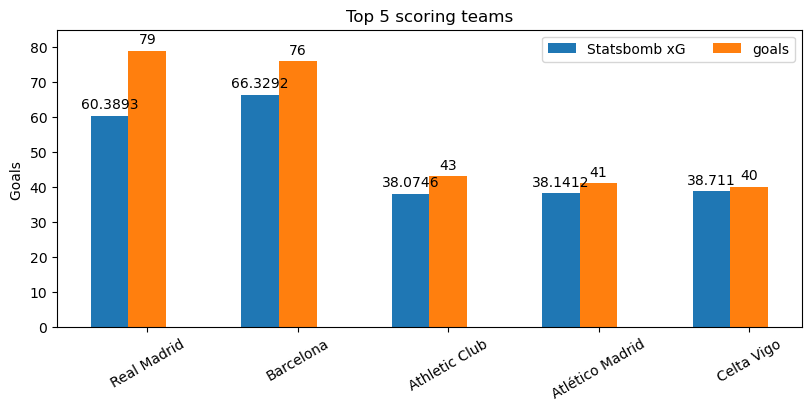

In [20]:
teams = LaLiga_team_summary_df['team'][0:5]
team_goals = {
    'Statsbomb xG': LaLiga_team_summary_df['statsbomb_xg'][0:5].round(),
    'goals': LaLiga_team_summary_df['goals'][0:5].round(),
}

x = np.arange(len(teams))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(8,4))

for attribute, measurement in team_goals.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Goals ')
ax.set_title('Top 5 scoring teams')
ax.set_xticks(x + width, teams)
ax.legend(loc='upper right', ncols=2)
ax.set_ylim(0, 85)
ax.tick_params(axis='x', rotation=30)
plt.show()

In [21]:
LaLiga_shots_df.columns

Index(['minute', 'second', 'team', 'shot_statsbomb_xg', 'player', 'position',
       'location', 'shot_body_part', 'shot_end_location', 'shot_first_time',
       'shot_technique', 'shot_type', 'type', 'shot_outcome', 'under_pressure',
       'distance', 'shot_angle'],
      dtype='object')

## Split training and test data, train model and define functions

In [22]:
cap_x_df, y_df = pd.concat([LaLiga_shots_df.iloc[:,:-4], LaLiga_shots_df.iloc[:,-3:]], axis=1),LaLiga_shots_df.iloc[:,-4].to_frame()

In [23]:
train_cap_x_df, test_cap_x_df, train_y_df, test_y_df = \
train_test_split(cap_x_df, y_df,
                 test_size=0.20,
                random_state=42,
                 shuffle=True,
                stratify=y_df)

In [24]:
target_attr = 'shot_outcome'

In [25]:
numerical_attrs = ['distance', 'minute', 'shot_angle']

In [26]:
nominal_attrs = ['shot_technique', 'shot_type', 'shot_body_part', 'position', 'shot_first_time', 'under_pressure']

In [27]:
numerical_transformer = Pipeline(
        steps=[("imputer", SimpleImputer()),
               ("scaler", StandardScaler())]
    )

In [28]:
nominal_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="constant", fill_value=False)),
               ('target_encoder', TargetEncoder(target_type='auto', random_state=42)),
               #("target_encoder", OrdinalEncoder()),
               ("scaler", StandardScaler())
               ]
    )

In [29]:
preprocessor = ColumnTransformer(
        transformers=[
            ('numerical', numerical_transformer, numerical_attrs),
            ('nominal', nominal_transformer, nominal_attrs)
        ]
    )

### The function below will be used to compare our models to the statsbomb model

In [30]:
def plot_comparison(model1, model1_name, model2, model2_name, outcome):
    plt.figure()
    df = pd.DataFrame({'model1':model1,'model2':model2,'outcome':outcome})
    no_goal = df[df['outcome']==0]
    plt.scatter(no_goal['model1'],no_goal['model2'], label='no goal', color='blue', alpha=0.6)
    goal = df[df['outcome']==1]
    plt.scatter(goal['model1'],goal['model2'], label='goal', color='orange', alpha=1)
    #plt.scatter(model1, model2,c=outcome)
    plt.xlabel(model1_name)
    plt.ylabel(model2_name)
    plt.xlim(0,1.1)
    plt.ylim(0,1.1)
    plt.legend()
    z = np.polyfit(model1, model2,1)
    #z = np.polyfit(df['model1'], df['model2'],1)
    p = np.poly1d(z)
    plt.plot(model1, p(model1),"r--")
    #plt.plot(df['model1'], p(df['model1']),"r--")
    print(model1_name)
    print("y=%.2fx+%.2f"%(z[0],z[1]))
    print("$R^2$=", r2_score(model1,model2))

## Train our estimators

LogisticRegression
y=1.03x+-0.01
$R^2$= 0.30981728639199746
SGDClassifier
y=1.15x+-0.01
$R^2$= -0.1809720694070509
RandomForestClassifier
y=0.72x+0.02
$R^2$= 0.5370453422778998
GradientBoostingClassifier
y=0.91x+0.01
$R^2$= 0.654488935572987
DecisionTreeClassifier
y=0.21x+0.08
$R^2$= 0.18652416221595225


,shots,goals,statsbomb_xg,LogisticRegression,SGDClassifier,RandomForestClassifier,GradientBoostingClassifier,DecisionTreeClassifier
0,5436,597,575.395912,598.884856,525.466842,619.39,579.201007,594.0


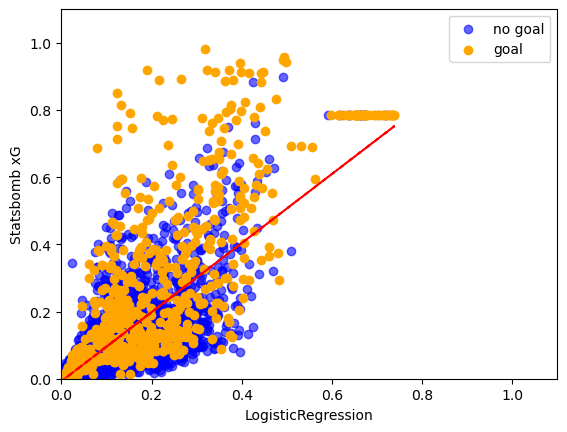

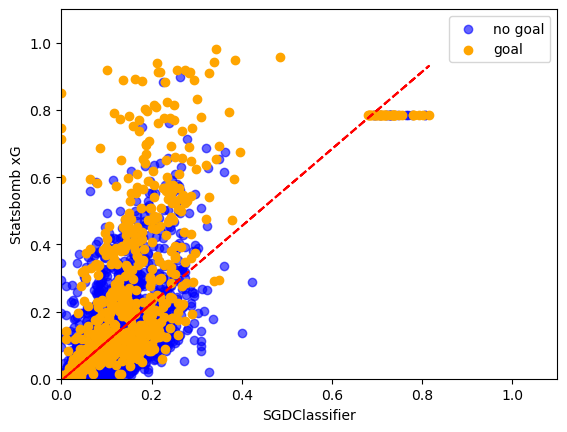

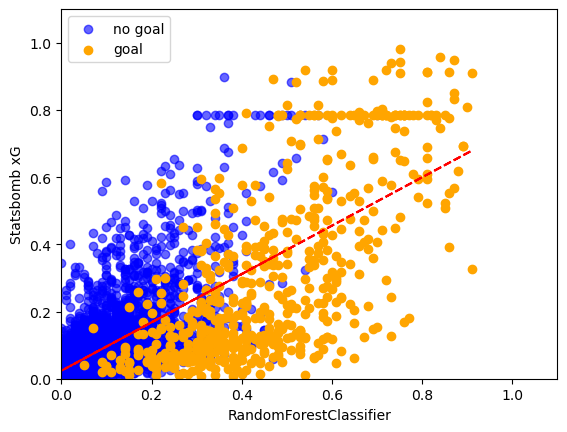

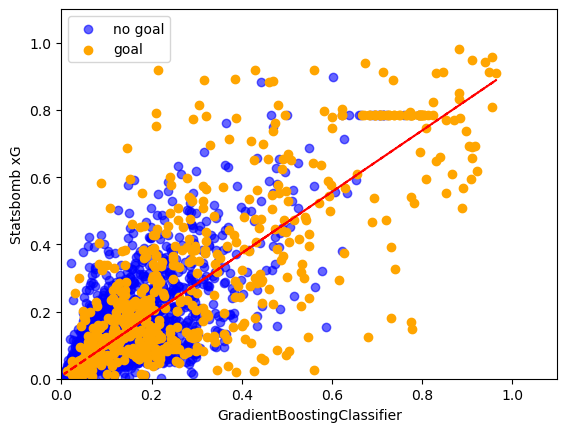

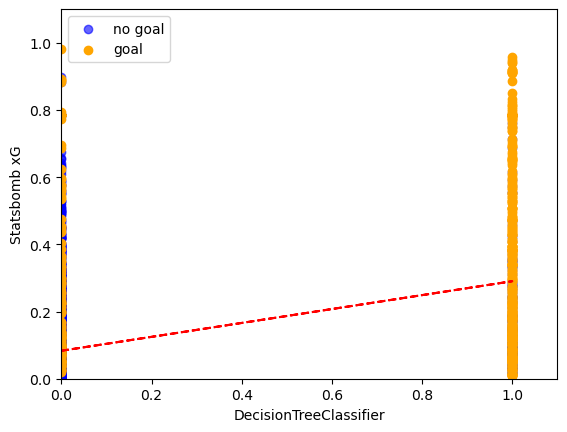

In [31]:
estimator_names = ['LogisticRegression', 'SGDClassifier', 'RandomForestClassifier', 
                  'GradientBoostingClassifier', 'DecisionTreeClassifier']

estimator_list = [LogisticRegression(), SGDClassifier(loss='log_loss'), 
                  RandomForestClassifier(criterion='log_loss'), GradientBoostingClassifier(loss='log_loss'),
                 DecisionTreeClassifier(criterion='log_loss')]
trained_estimator_dict = {}
#model_summary = pd.DataFrame(columns = ['shots', 'goals', 'statsbomb_xg']
model_summary = {}
model_summary['shots'] = [len(train_y_df[target_attr])]
model_summary['goals'] = [train_y_df[target_attr].value_counts()[1]]
model_summary['statsbomb_xg'] = [sum(train_cap_x_df['shot_statsbomb_xg'])]
for estimator_name, estimator in zip(estimator_names, estimator_list):
    composite_estimator = Pipeline(steps=[('preprocessor', preprocessor), ('estimator', estimator)])
    trained_estimator_dict[estimator_name] = composite_estimator.fit(train_cap_x_df, train_y_df.values.ravel())
    predictions = trained_estimator_dict[estimator_name].predict_proba(train_cap_x_df)[:,1]
    SBModel = train_cap_x_df['shot_statsbomb_xg']
    shot_outcome = train_y_df[target_attr]
    model_summary[estimator_name] = [sum(predictions)]
    plot_comparison(predictions, estimator_name, SBModel, 'Statsbomb xG', shot_outcome)
#print(pd.DataFrame(model_summary))
pd.DataFrame.from_dict(model_summary)

## Select Best Model and examine Permutation Importance

In [32]:
best_model_name = 'GradientBoostingClassifier'
best_model = trained_estimator_dict[best_model_name]

In [33]:
feature_importances = permutation_importance(
    best_model, train_cap_x_df, train_y_df.values.ravel())

In [34]:
mean_feature_importances = pd.Series(feature_importances.importances_mean, index=train_cap_x_df.columns)
mean_feature_importances.sort_values(ascending=False)
std_feature_importances = pd.Series(feature_importances.importances_std, index=train_cap_x_df.columns)
std_feature_importances

minute               0.000396
second               0.000000
team                 0.000000
shot_statsbomb_xg    0.000000
player               0.000000
position             0.000926
location             0.000000
shot_body_part       0.000586
shot_end_location    0.000000
shot_first_time      0.000442
shot_technique       0.000575
shot_type            0.000609
type                 0.000000
under_pressure       0.000275
distance             0.001377
shot_angle           0.000586
dtype: float64

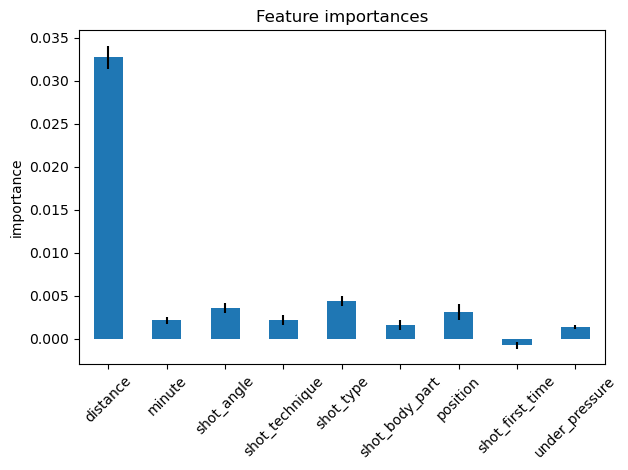

In [35]:
fig, ax = plt.subplots()
#mean_feature_importances[['distance','shot_body_part', 'shot_type', 'shot_angle']].plot.bar(
#    yerr=std_feature_importances[['distance','shot_body_part', 'shot_type', 'shot_angle']], ax=ax)
mean_feature_importances[numerical_attrs+nominal_attrs].plot.bar(
    yerr=std_feature_importances[numerical_attrs+nominal_attrs], ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("importance")
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

## Evaluate on Test Set

GradientBoostingClassifier
y=0.83x+0.02
$R^2$= 0.6084742273155539


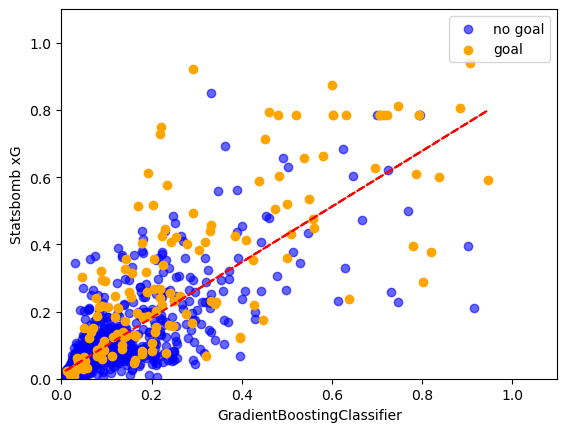

In [36]:
test_predictions = best_model.predict_proba(test_cap_x_df)[:,1]
test_SBModel = test_cap_x_df['shot_statsbomb_xg']
test_shot_outcome = test_y_df[target_attr]
plot_comparison(test_predictions, best_model_name, test_SBModel, 'Statsbomb xG', test_shot_outcome)

## Observe behavior on totality of test set

In [37]:
model_summary = pd.DataFrame(columns = ['shots', 'goals', 'statsbomb_xg', 'best_model_xg'])
shots = len(test_y_df[target_attr])
goals = test_y_df[target_attr].value_counts()[1]
statsbomb_xg = sum(test_cap_x_df['shot_statsbomb_xg'])
best_model_xg = sum(test_predictions)
new_row = pd.Series({'shots': shots, 'goals': goals, 'statsbomb_xg': statsbomb_xg, 'best_model_xg': best_model_xg})
model_summary.loc[len(model_summary)]=new_row
model_summary

,shots,goals,statsbomb_xg,best_model_xg
0,1360.0,149.0,148.531641,153.399089


## Examine on Week to Week basis
### Get matches for a particular team

In [38]:
def get_games_for_team(team):
    df = LaLiga[(LaLiga['home_team']==team)|(LaLiga['away_team']==team)]
    df = df.sort_values(by='match_week')
    return df

In [39]:
Real_Madrid_games = get_games_for_team('Real Madrid')
Real_Madrid_games

,match_id,match_date,kick_off,competition,season,home_team,away_team,home_score,away_score,match_status,...,last_updated_360,match_week,competition_stage,stadium,referee,home_managers,away_managers,data_version,shot_fidelity_version,xy_fidelity_version
342,3825567,2015-08-23,20:30:00.000,Spain - La Liga,2015/2016,Sporting Gijón,Real Madrid,0,0,available,...,None,1,Regular Season,Estadio Municipal El Molinón,Xavier Estrada Fernández,Abelardo Fernández Antuña,Rafael Benítez Maudes,1.1.0,2,2
117,3825572,2015-08-29,22:30:00.000,Spain - La Liga,2015/2016,Real Madrid,Real Betis,5,0,available,...,None,2,Regular Season,Estadio Santiago Bernabéu,Alejandro José Hernández Hernández,Rafael Benítez Maudes,José Mel Pérez,1.1.0,2,2
331,3825581,2015-09-12,16:00:00.000,Spain - La Liga,2015/2016,Espanyol,Real Madrid,0,6,available,...,None,3,Regular Season,RCDE Stadium,Iñaki Bikandi Garrido,Sergio González Soriano,Rafael Benítez Maudes,1.1.0,2,2
323,3825590,2015-09-19,16:00:00.000,Spain - La Liga,2015/2016,Real Madrid,Granada,1,0,available,...,None,4,Regular Season,Estadio Santiago Bernabéu,Juan Martínez Munuera,Rafael Benítez Maudes,José Ramón Sandoval Huertas,1.1.0,2,2
314,3825602,2015-09-23,21:00:00.000,Spain - La Liga,2015/2016,Athletic Club,Real Madrid,1,2,available,...,None,5,Regular Season,San Mamés Barria,Antonio Miguel Mateu Lahoz,Ernesto Valverde Tejedor,Rafael Benítez Maudes,1.1.0,2,2
310,3825606,2015-09-26,18:15:00.000,Spain - La Liga,2015/2016,Real Madrid,Málaga,0,0,available,...,None,6,Regular Season,Estadio Santiago Bernabéu,José Luis González González,Rafael Benítez Maudes,Javier Gracia Carlos,1.1.0,2,2
304,3825621,2015-10-04,20:30:00.000,Spain - La Liga,2015/2016,Atlético Madrid,Real Madrid,1,1,available,...,None,7,Regular Season,Estadio Vicente Calderón,Alberto Undiano Mallenco,Diego Pablo Simeone,Rafael Benítez Maudes,1.1.0,2,2
301,3825625,2015-10-17,16:00:00.000,Spain - La Liga,2015/2016,Real Madrid,Levante UD,3,0,available,...,None,8,Regular Season,Estadio Santiago Bernabéu,José María Sánchez Martínez,Rafael Benítez Maudes,Luis Lucas Alcaraz González,1.1.0,2,2
293,3825635,2015-10-24,16:00:00.000,Spain - La Liga,2015/2016,Celta Vigo,Real Madrid,1,3,available,...,None,9,Regular Season,Abanca-Balaídos,Carlos Clos Gómez,Manuel Eduardo Berizzo,Rafael Benítez Maudes,1.1.0,2,2
109,3825643,2015-10-31,17:00:00.000,Spain - La Liga,2015/2016,Real Madrid,Las Palmas,3,1,available,...,None,10,Regular Season,Estadio Santiago Bernabéu,Santiago Jaime Latre,Rafael Benítez Maudes,Enrique Setién Solar,1.1.0,2,2


## Examine individual matches
We'll look at a match after matchweek 28, since all the matches before matchweek 28 are what are used to train the model.

In [40]:
next_game_week = 35

In [41]:
match = Real_Madrid_games[Real_Madrid_games['match_week']==next_game_week]['match_id'].iloc[0]

In [42]:
def cumulative_sums(array):
    return [sum(array[:i+1]) for i in range(len(array))]

In [43]:
def display_match_results_with_xG(league_df,match, display_shots=False, display_chart=False):
    match_shots_df = pd.DataFrame(columns=relevant_attributes)
    #print(match)
    home_team = league_df[league_df['match_id']==match]['home_team'].values[0]
    home_score = league_df[league_df['match_id']==match]['home_score'].values[0]
    away_team = league_df[league_df['match_id']==match]['away_team'].values[0]
    away_score = league_df[league_df['match_id']==match]['away_score'].values[0]

    match_df = sb.events(match_id=match)
    new_match_df = match_df[relevant_attributes][match_df['type']=='Shot']

    match_shots_df = pd.concat([match_shots_df, new_match_df], ignore_index=True)

    match_shots_df['shot_outcome'] = match_shots_df['shot_outcome'].replace(
        to_replace={'Off T': 0, 'Blocked': 0, 'Saved': 0, 'Goal': 1, 'Wayward': 0, 'Post': 0,
                   'Saved to Post': 0, 'Saved Off Target': 0})

    match_shots_df['distance'] = match_shots_df.apply(lambda row: np.sqrt(np.abs(
        row.location[0]-120)**2 + np.abs(row.location[1]-40)**2), axis=1)
    match_shots_df['shot_angle'] = match_shots_df.apply(
        lambda row: np.arctan2(np.abs(40-row.location[1]), np.abs(120-row.location[0])), axis=1)
    match_shots_df = match_shots_df.sort_values(by='minute')
    
    cap_x_df = pd.concat([match_shots_df.iloc[:,:-4], 
                              match_shots_df.iloc[:,-3:]], axis=1)
    
    predictions = best_model.predict_proba(cap_x_df)[:,1]
    predictions_df = pd.DataFrame({'best_model': predictions})
    match_shots_df['best_model']= predictions_df
    
    home_shots_df = match_shots_df[match_shots_df['team']==home_team]
    away_shots_df = match_shots_df[match_shots_df['team']==away_team]

    home_cap_x_df = pd.concat([home_shots_df.iloc[:,:-5], 
                                home_shots_df.iloc[:,-4:]], axis=1)
    away_cap_x_df = pd.concat([away_shots_df.iloc[:,:-5], 
                                away_shots_df.iloc[:,-4:]], axis=1)
    
    home_predictions = home_cap_x_df['best_model']
    away_predictions = away_cap_x_df['best_model']
    
    home_total_best_model_xG = sum(home_predictions)
    away_total_best_model_xG = sum(away_predictions)
    home_statsbomb_xG = sum(home_cap_x_df['shot_statsbomb_xg'])
    away_statsbomb_xG = sum(away_cap_x_df['shot_statsbomb_xg'])
    if display_shots == True:
        display(match_shots_df)
    print("Proposed model")
    print("%s (%.2f) %.0f-%.0f (%.2f) %s" % (home_team, home_total_best_model_xG, home_score, away_score, away_total_best_model_xG, away_team))
    print("statsbomb xG")
    print("%s (%.2f) %.0f-%.0f (%.2f) %s" % (home_team, home_statsbomb_xG, home_score, away_score, away_statsbomb_xG, away_team))
    if display_chart==True:
        home_team_xg = [0]
        away_team_xg = [0]
        home_min = [0]
        away_min = [0]
        for x in range(len(match_shots_df)):
            if match_shots_df['team'][x] == home_team:
                home_team_xg.append(match_shots_df['best_model'][x])
                home_min.append(match_shots_df['minute'][x])
            if match_shots_df['team'][x] == away_team:
                away_team_xg.append(match_shots_df['best_model'][x])
                away_min.append(match_shots_df['minute'][x])
        home_cumulative_xg = cumulative_sums(home_team_xg)
        away_cumulative_xg = cumulative_sums(away_team_xg)

        fig, ax = plt.subplots(figsize= (10,5))
        plt.xticks([0,15,30,45,60,75,90])
        plt.xlabel("minute")
        plt.ylabel("model xG")
        plt.title("Cumulative xG by minute")
        home, = ax.step(x=home_min, y=home_cumulative_xg, label=home_team)
        away, = ax.step(x=away_min, y=away_cumulative_xg, label=away_team)
        ax.legend(handles=[home,away])
    #return match_shots_df

Proposed model
Rayo Vallecano (1.56) 2-3 (2.52) Real Madrid
statsbomb xG
Rayo Vallecano (1.36) 2-3 (1.66) Real Madrid


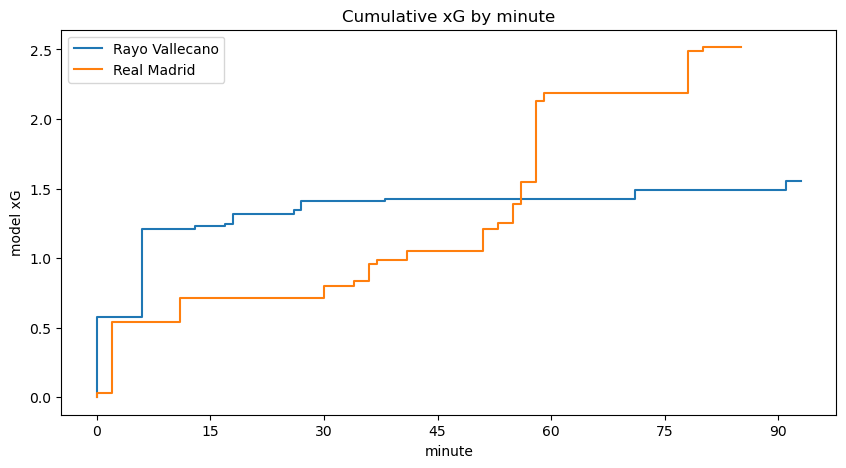

In [44]:
display_match_results_with_xG(Real_Madrid_games,match, display_shots=False, display_chart=True)